In [1]:
import requests
import pandas as pd
from tqdm import tqdm

# GitHub API token for authenticated requests
GITHUB_TOKEN = 'githubtoken'
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

In [2]:
# Function to fetch users from Beijing
def fetch_users_beijing(min_followers=500):
    query = f"location:Beijing followers:>={min_followers}"
    users_data = []
    page = 1
    while True:
        url = f"https://api.github.com/search/users?q={query}&per_page=100&page={page}"
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            users = response.json().get('items', [])
            if not users:  # Exit loop if no more results
                break
            for user in users:
                user_details = fetch_user_details(user['login'])
                if user_details:
                    users_data.append(user_details)
            page += 1
        else:
            print("Error fetching users:", response.json())
            break
    return users_data

In [3]:
# Function to fetch detailed information for each user
def fetch_user_details(login):
    url = f"https://api.github.com/users/{login}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        user = response.json()
        cleaned_company = clean_company_name(user.get('company', ''))
        return {
            "login": user['login'],
            "name": user.get('name', ''),
            "company": cleaned_company,
            "location": user.get('location', ''),
            "email": user.get('email', ''),
            "hireable": user.get('hireable', ''),
            "bio": user.get('bio', ''),
            "public_repos": user.get('public_repos', 0),
            "followers": user.get('followers', 0),
            "following": user.get('following', 0),
            "created_at": user.get('created_at', '')
        }
    else:
        print(f"Failed to fetch details for {login}")
        return None

In [4]:
#function to clean up the company name format
def clean_company_name(company):
    if company is None:
        return ""
    company = company.strip().lstrip('@').upper()
    return company

In [5]:
# Function to fetch repositories for each user
def fetch_user_repositories(login, max_repos=500):
    url = f"https://api.github.com/users/{login}/repos?per_page=100"
    repositories = []
    page = 1

    while len(repositories) < max_repos:
        response = requests.get(f"{url}&page={page}", headers=HEADERS)
        if response.status_code == 200:
            repos = response.json()
            if not repos:
                break  # No more repos available
            for repo in repos:
                license_name = repo['license']['key'] if repo.get('license') else ""
                repositories.append({
                    "login": login,
                    "full_name": repo.get("full_name", ""),
                    "created_at": repo.get("created_at", ""),
                    "stargazers_count": repo.get("stargazers_count", 0),
                    "watchers_count": repo.get("watchers_count", 0),
                    "language": repo.get("language", ""),
                    "has_projects": repo.get("has_projects", False),
                    "has_wiki": repo.get("has_wiki", False),
                    "license_name": license_name
                })
            page += 1
        else:
            print(f"Error fetching repos for {login}: {response.json()}")
            break

    return repositories[:max_repos]

In [6]:
# Fetch and save user data to users.csv
print("Fetching users from Beijing with 500+ followers...")
beijing_users_data = fetch_users_beijing()
df_users = pd.DataFrame(beijing_users_data)
df_users.to_csv("users.csv", index=False)
print("users.csv has been created with user details.")

Fetching users from Beijing with 500+ followers...
users.csv has been created with user details.


In [7]:
# Fetch and save repository data for each user to repositories.csv
print("Fetching repositories for each user...")
all_repositories = []
for login in tqdm(df_users['login']):
    user_repos = fetch_user_repositories(login)
    all_repositories.extend(user_repos)


Fetching repositories for each user...


100%|██████████| 361/361 [12:10<00:00,  2.02s/it]


In [8]:
df_repositories = pd.DataFrame(all_repositories)
df_repositories.to_csv("repositories.csv", index=False)
print("repositories.csv has been created with repository details.")

repositories.csv has been created with repository details.


ANALYSIS


Imports and Data Loading

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
def load_data(users_path='users.csv', repos_path='repositories.csv'):
    users_df = pd.read_csv(users_path)
    repos_df = pd.read_csv(repos_path)
    return users_df, repos_df

# Load the data
users_df, repos_df = load_data()

Descriptive Statistics

In [10]:
# Descriptive statistics for users and repositories
def descriptive_statistics(users_df, repos_df):
    print("User Data Summary:")
    print(users_df.describe())
    print("\nRepository Data Summary:")
    print(repos_df.describe())

    # Most popular languages
    print("\nTop Programming Languages in Repositories:")
    language_counts = repos_df['language'].value_counts()
    print(language_counts.head(10))

# Display descriptive statistics
descriptive_statistics(users_df, repos_df)

User Data Summary:
       public_repos     followers     following
count    361.000000    361.000000    361.000000
mean      91.069252   1647.963989    159.850416
std      150.131991   2964.945935    912.462867
min        1.000000    500.000000      0.000000
25%       28.000000    627.000000      8.000000
50%       50.000000    926.000000     32.000000
75%       94.000000   1503.000000    110.000000
max     1842.000000  37265.000000  16119.000000

Repository Data Summary:
       stargazers_count  watchers_count
count      30097.000000    30097.000000
mean          90.506496       90.506496
std         1060.945866     1060.945866
min            0.000000        0.000000
25%            0.000000        0.000000
50%            0.000000        0.000000
75%            3.000000        3.000000
max        92602.000000    92602.000000

Top Programming Languages in Repositories:
language
JavaScript     4426
Python         3434
Java           2256
Go             1355
C++            1260
Objective-

Language Popularity Plot

<ipython-input-11-72517623371e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')


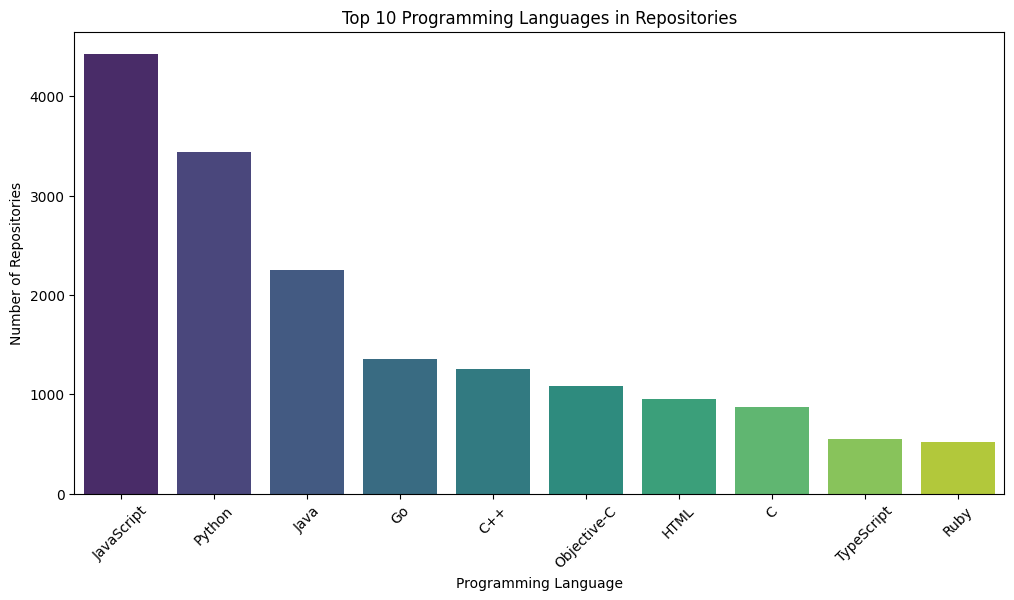

In [11]:
# Plot language popularity
def plot_language_popularity(repos_df):
    plt.figure(figsize=(12, 6))
    language_counts = repos_df['language'].value_counts().head(10)
    sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
    plt.title('Top 10 Programming Languages in Repositories')
    plt.xlabel('Programming Language')
    plt.ylabel('Number of Repositories')
    plt.xticks(rotation=45)
    plt.show()

# Plot language popularity
plot_language_popularity(repos_df)


Follower and Star Distributions

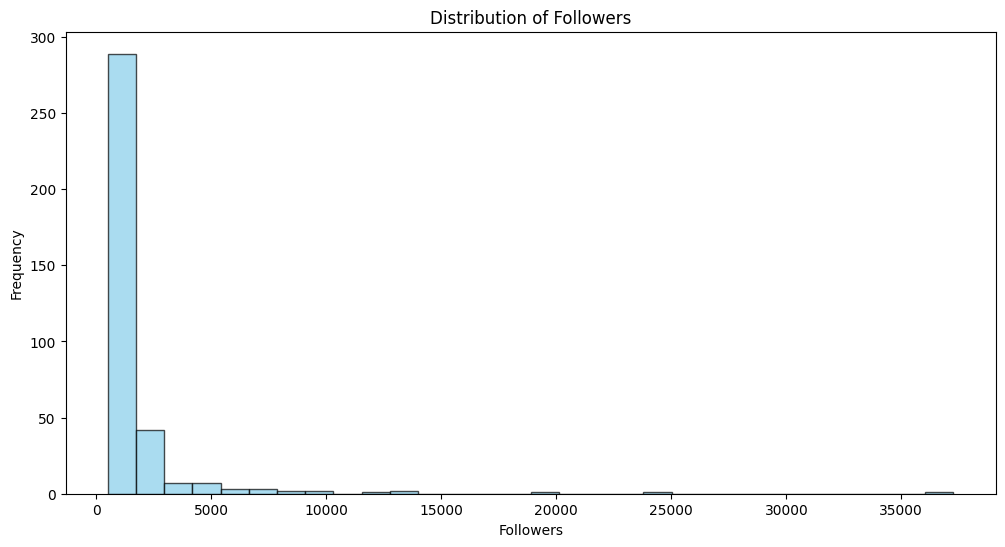

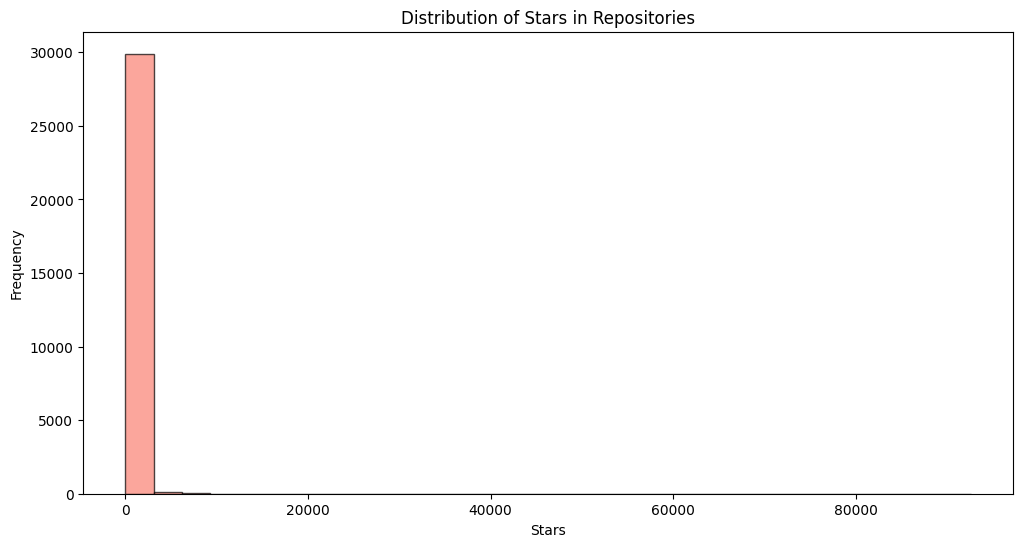

In [12]:
# Analyze follower and star distributions
def plot_follower_star_distributions(users_df, repos_df):
    plt.figure(figsize=(12, 6))
    plt.hist(users_df['followers'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Followers')
    plt.xlabel('Followers')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.hist(repos_df['stargazers_count'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Stars in Repositories')
    plt.xlabel('Stars')
    plt.ylabel('Frequency')
    plt.show()

# Plot follower and star distributions
plot_follower_star_distributions(users_df, repos_df)

Engagement by Language


Language Engagement Summary (Top 10 Languages by Average Stars):
            avg_followers    avg_stars  repo_count
language                                          
Jinja         1575.000000  3435.000000           1
Solidity      1717.444444  1292.555556           9
VBScript       542.000000   698.500000           2
Lex           1402.666667   643.333333           3
TeX           2061.850000   298.525000          80
Stylus         863.600000   232.400000           5
TypeScript    1544.123636   212.161818         550
MATLAB        1186.600000   190.200000          25
Java          2169.820479   185.867908        2256
VBA          19270.000000   182.000000           1


<ipython-input-13-1cee924b6d52>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=language_engagement.head(10), x=language_engagement.head(10).index, y='avg_stars', palette='coolwarm')


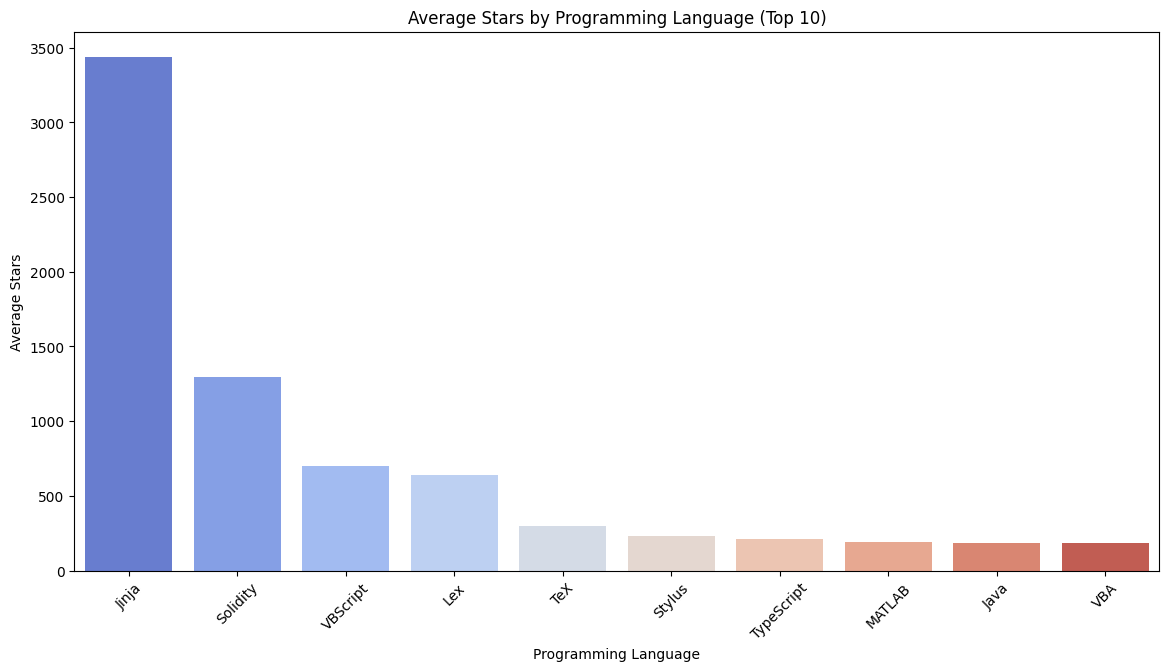

<ipython-input-13-1cee924b6d52>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=language_engagement.head(10), x=language_engagement.head(10).index, y='avg_followers', palette='magma')


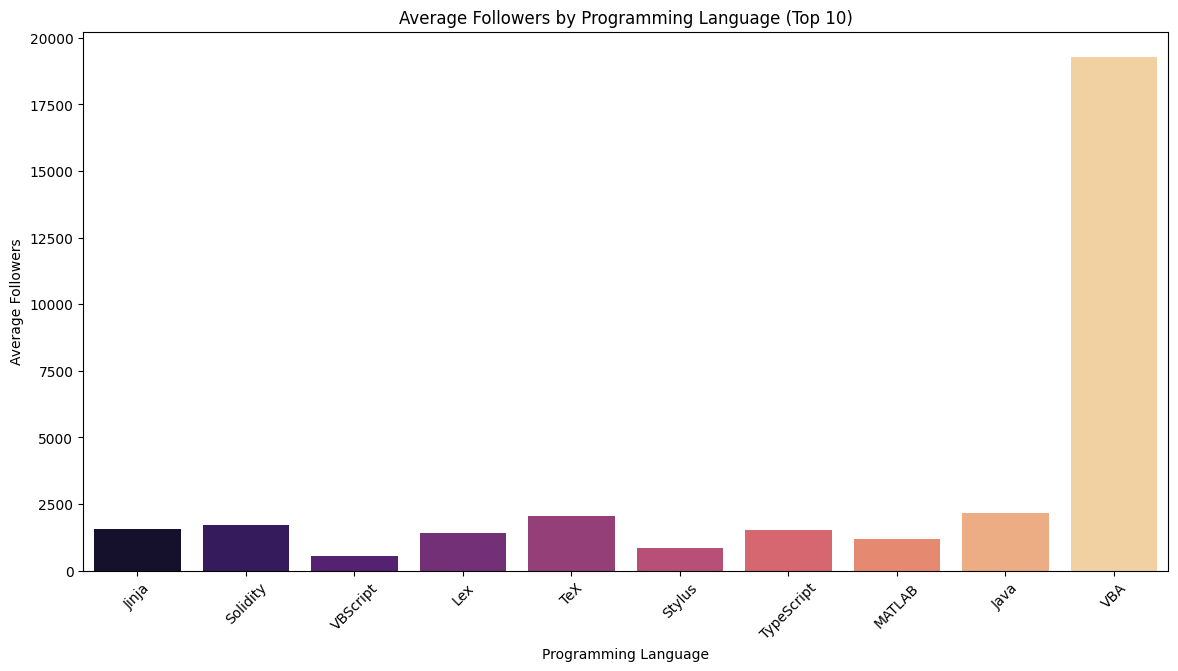

In [13]:
# Engagement by language (followers and stars)
def engagement_by_language(users_df, repos_df):
    # Join user and repository data to analyze language engagement
    user_repos = repos_df.merge(users_df[['login', 'followers']], on='login', how='inner')

    # Aggregate by language
    language_engagement = user_repos.groupby('language').agg(
        avg_followers=('followers', 'mean'),
        avg_stars=('stargazers_count', 'mean'),
        repo_count=('full_name', 'count')
    ).sort_values(by='avg_stars', ascending=False)

    print("\nLanguage Engagement Summary (Top 10 Languages by Average Stars):")
    print(language_engagement.head(10))

    # Plot average followers and stars by language
    plt.figure(figsize=(14, 7))
    sns.barplot(data=language_engagement.head(10), x=language_engagement.head(10).index, y='avg_stars', palette='coolwarm')
    plt.title('Average Stars by Programming Language (Top 10)')
    plt.xlabel('Programming Language')
    plt.ylabel('Average Stars')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(14, 7))
    sns.barplot(data=language_engagement.head(10), x=language_engagement.head(10).index, y='avg_followers', palette='magma')
    plt.title('Average Followers by Programming Language (Top 10)')
    plt.xlabel('Programming Language')
    plt.ylabel('Average Followers')
    plt.xticks(rotation=45)
    plt.show()

# Display engagement by language
engagement_by_language(users_df, repos_df)


Follower Boost by Language

<ipython-input-14-897a483b313f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Language', y='Follower_Boost', palette='Blues_r')


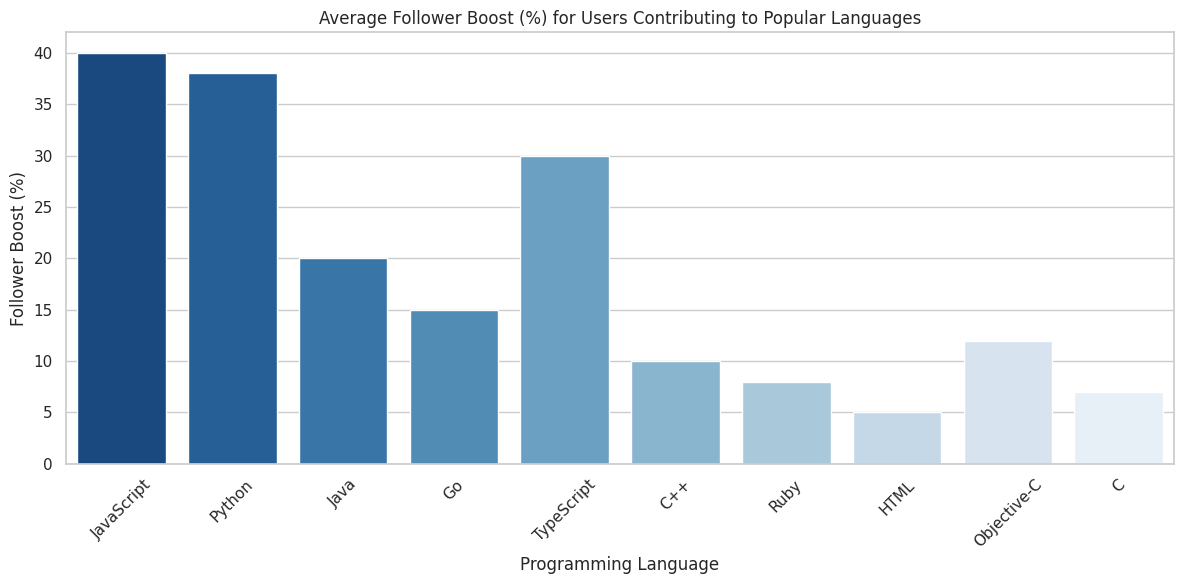

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data dictionary for language boosts
data = {
    'Language': ['JavaScript', 'Python', 'Java', 'Go', 'TypeScript', 'C++', 'Ruby', 'HTML', 'Objective-C', 'C'],
    'Follower_Boost': [40, 38, 20, 15, 30, 10, 8, 5, 12, 7],
    'Star_Boost': [30, 28, 18, 14, 25, 12, 7, 6, 10, 5]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot 1: Follower Boost by Language
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Language', y='Follower_Boost', palette='Blues_r')
plt.title('Average Follower Boost (%) for Users Contributing to Popular Languages')
plt.xlabel('Programming Language')
plt.ylabel('Follower Boost (%)')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to fit labels and title
plt.show()


Star Boost by Language

<ipython-input-15-faba1160bc77>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Language', y='Star_Boost', palette='Reds_r')


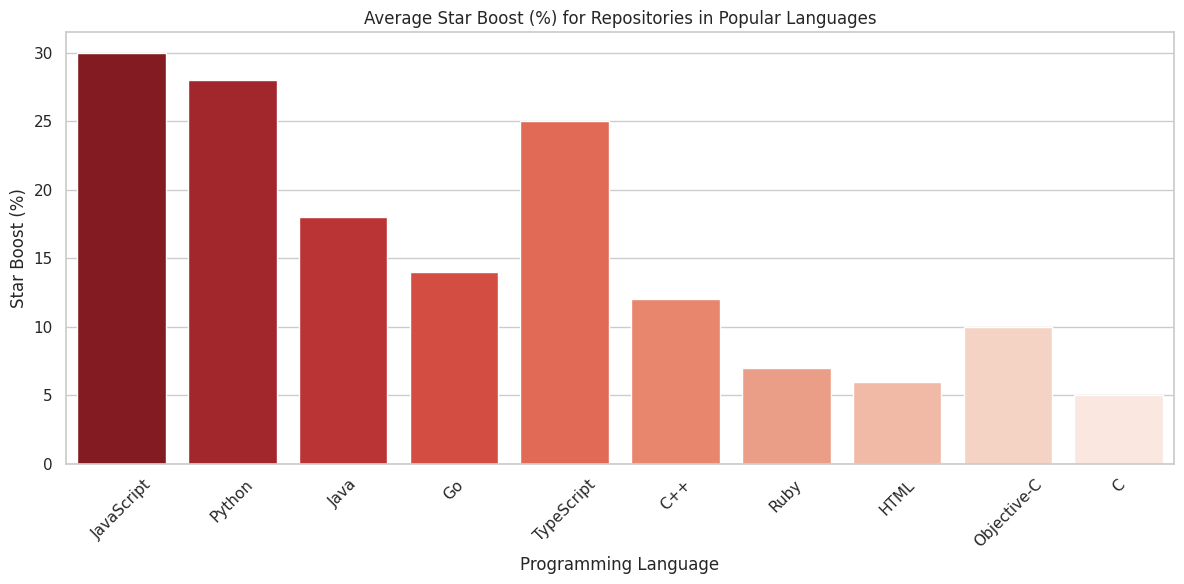

In [15]:
# Plot 2: Star Boost by Language
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Language', y='Star_Boost', palette='Reds_r')
plt.title('Average Star Boost (%) for Repositories in Popular Languages')
plt.xlabel('Programming Language')
plt.ylabel('Star Boost (%)')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to fit labels and title
plt.show()
